In [0]:
from numpy import hstack
from numpy import zeros
from numpy import ones
import numpy as np
import phik
import datetime, os
import seaborn as sns
from phik import report
from numpy.random import rand
from numpy.random import randn
from numpy.random import random
from keras.models import Sequential
from keras.layers import Dense
from keras.models import load_model
from matplotlib import pyplot
from tensorboard import notebook
from sklearn.metrics.pairwise import euclidean_distances 
from sklearn.preprocessing import normalize
from sklearn import preprocessing
%matplotlib inline
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd

Using TensorFlow backend.
C:\Users\Michael Kam\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Michael Kam\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Michael Kam\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users

In [0]:
### Adult dataset

colnames = ['age', 'workclass', 'fnlwgt', 'education', 'education.num', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week', 'native.country', 'income']
df_raw = pd.read_csv('adult.data', names=colnames)
col_dtype = df_raw.dtypes.to_dict()
#df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", names=colnames)
features = colnames
cat_features = ['workclass', 'education', 'education.num','marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country', 'income']
num_features = list(set(colnames) - set(cat_features))

In [0]:
df = df_raw[features]
#df[num_features] = (df_raw[num_features] - df_raw[num_features].mean()) / (df_raw[num_features].std())
df.loc[:,num_features] = (df_raw[num_features] - df_raw[num_features].mean()) / (df_raw[num_features].max() - df_raw[num_features].min())

In [0]:

def cast_datatype(df, col_dtype):

    for col in df.columns:
        df[col] = df[col].astype(col_dtype[col])
    
    return df


In [0]:
def categorical_mapping(data,feature):
    
    featureMap=dict()
    data[feature] = data[feature].astype(str)
    freq_dist = data[feature].value_counts(normalize=True, sort=True).cumsum()
    unique_vals = freq_dist.index.tolist()
   
    idx = 0
    for i in unique_vals:
        if idx == 0:
            featureMap[i] = (freq_dist[idx]/2 , freq_dist[idx]/6, 0, freq_dist[idx]) #np.random.normal(freq_dist[idx], (freq_dist[idx]-0)/6)
        else:
            featureMap[i] = ((freq_dist[idx]+freq_dist[idx-1])/2, (freq_dist[idx]-freq_dist[idx-1])/6, freq_dist[idx-1], freq_dist[idx])
        idx += 1
    return featureMap

In [0]:
catFeatureMap = dict()

for col in cat_features:
    catFeatureMap[col] = categorical_mapping(df, col)
    df.loc[:,col] = df[col].map(catFeatureMap[col])
    df.loc[:,col] = df[col].apply(lambda x: np.random.normal(x[0], x[1]))
  

In [0]:
dataset = df.values

In [0]:
dataset

array([[ 0.00573087,  0.91898622, -0.07624344, ..., -0.00446384,
         0.36375855,  0.58835731],
       [ 0.1564158 ,  0.7371145 , -0.07230774, ..., -0.27997404,
         0.49329092,  0.36948653],
       [-0.00796776,  0.33124882,  0.01756811, ..., -0.00446384,
         0.46929735,  0.32906819],
       ...,
       [ 0.26600484,  0.24278159, -0.02571845, ..., -0.00446384,
         0.25342692,  0.43535527],
       [-0.22714585,  0.24333   ,  0.007954  , ..., -0.20854547,
         0.43378188,  0.41989139],
       [ 0.18381306,  0.9485822 ,  0.06665804, ..., -0.00446384,
         0.3440851 ,  0.83738498]])

# Latest Version

In [0]:

# define the standalone discriminator model
def define_discriminator(n_inputs=2):
    model = Sequential()
    model.add(Dense(256, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
    model = Sequential()
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(256, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(n_outputs, activation='linear'))
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

# generate n real samples with class labels
def generate_real_samples(n):    
    X_train = dataset
    data_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=n)]
    # generate class labels
    y = ones((n, 1))
    return data_batch, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = zeros((n, 1))
    return X, y

# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
    # prepare real samples
    x_real, y_real = generate_real_samples(n)
    # evaluate discriminator on real examples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    # evaluate discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print(epoch, acc_real, acc_fake)
    

def generate_fake_table(generator, discriminator, latent_dim, n=100):
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    return x_fake

def plot_loss(loss_real_, loss_fake_, loss_gan_):
    pyplot.plot(loss_real_, label='loss disc real')
    pyplot.plot(loss_fake_, label='loss disc fake')
    pyplot.legend()
    pyplot.savefig('plot_loss.png')
    pyplot.close()
    

def plot_acc(acc_real_, acc_fake_):
    pyplot.plot(acc_real_, label='acc real')
    pyplot.plot(acc_fake_, label='acc fake')
    pyplot.legend()
    pyplot.savefig('plot_accuracy.png')
    pyplot.close()
    

def label_noise(y, prob):
    n_noise = int(prob * y.shape[0])
    noise_indices = [np.random.randint(0, y.shape[0]) for i in np.arange(0, n_noise)]
    y[noise_indices] = 1 - y[noise_indices]
    return y
    
def label_smoothing(y, y_class):
    if y_class == 'real':
        return y - 0.1 + (random(y.shape) * 0.5)
    else:
        return y + (random(y.shape) * 0.1)
    
    
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=2000):
    acc_real_ = []
    acc_fake_ = []
    loss_real_ = []
    loss_fake_ = []
    loss_gan_ = []
    
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare real samples
        x_real, y_real = generate_real_samples(half_batch)
        
        y_real = label_noise(y_real, 0.1)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        
        # update discriminator
        loss_real_i, acc_real_i = d_model.train_on_batch(x_real, y_real)
        loss_fake_i, acc_fake_i = d_model.train_on_batch(x_fake, y_fake)
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        loss_gan_i = gan_model.train_on_batch(x_gan, y_gan)
        acc_real_.append(acc_real_i)
        loss_real_.append(loss_real_i)
        acc_fake_.append(acc_fake_i)
        loss_fake_.append(loss_fake_i)
        loss_gan_.append(loss_gan_i)
        # evaluate the model every n_eval epochs
        if (i+1) % n_eval == 0:
            summarize_performance(i, g_model, d_model, latent_dim)
    plot_loss(loss_real_, loss_fake_, loss_gan_)
    plot_acc(acc_real_, acc_fake_)
    
    return acc_real_, acc_fake_


In [0]:
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator(dataset.shape[1])
# create the generator
generator = define_generator(latent_dim, dataset.shape[1])
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
#train(generator, discriminator, gan_model, latent_dim)
acc_real_, acc_fake_ = train(generator, discriminator, gan_model, latent_dim, n_epochs=10000)

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1999 0.63 0.33
3999 0.64 0.91
5999 0.59 0.78
7999 0.65 0.94
9999 0.56 0.89


In [0]:
fake_data = generate_fake_table(generator, discriminator, latent_dim, df.shape[0])

In [0]:
df_fake_norm = pd.DataFrame(fake_data, columns = features)

In [0]:
df_fake_norm.head(5)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,-0.206727,0.198770,-0.104216,1.083852,1.038339,0.697424,0.831463,0.715741,0.664382,0.700375,-0.009976,-0.000379,-0.047381,0.322808,0.275531
1,-0.067283,0.168035,-0.071718,0.956041,0.912374,0.523990,0.583288,0.371540,0.452205,0.469293,-0.015050,-0.015091,0.041647,0.310430,0.386904
2,-0.128696,0.114254,-0.095919,0.201482,0.231793,0.820963,0.373400,0.713674,0.394599,0.915800,0.001354,-0.029572,0.010699,0.451081,0.262016
3,-0.252011,0.157702,-0.109971,0.584571,0.552889,0.660880,0.730356,0.643851,0.521978,0.579778,-0.016718,-0.011591,-0.002154,0.350700,0.236157
4,-0.102369,0.224856,-0.107818,0.760335,0.758450,0.935186,0.696772,0.866334,0.551734,0.940944,-0.017164,-0.024127,0.002252,0.390403,0.296370


In [0]:
df_fake = pd.DataFrame(fake_data, columns = features)

# Privacy

## Euclidean Distance 

In [0]:
#df_fake_norm.to_csv('adult_fake_norm_100k_new.csv', header=True, index=False)
df_fake_norm.to_csv('adult_fake_norm_10k_new.csv', header=True, index=False)
#df.to_csv('adult_norm.csv', header=True, index=False)

In [0]:
shortest_dist = np.zeros((df.shape[0], 2), dtype=np.float32)
#shortest_dist = np.zeros(df.shape[0], dtype=np.float32)

for index, row in df.iterrows():
    row = row.values.reshape(1,df.shape[1])
    dist_arr = euclidean_distances(row, df_fake_norm.values)
    shortest_dist[index, 0] = np.min(dist_arr)
    shortest_dist[index, 1] = np.argmin(dist_arr)

In [0]:
print(np.mean(shortest_dist[:,0]))
print(np.std(shortest_dist[:,0]))

0.5120162
0.17805955


In [0]:
sdist = pd.DataFrame(shortest_dist)

In [0]:
closest5 = sdist.sort_values(0).head(5)

In [0]:
closest5

,0,1
23816,0.098054,13398.0
15041,0.104009,7563.0
32552,0.107000,15110.0
15858,0.108246,13236.0
290,0.114012,16704.0


In [0]:
sdist.to_csv('Adult_10k_Distance_new.csv', index=False)

In [0]:
idx_ori = closest5.index.values
idx_syn = closest5[1].values
df_raw.iloc[idx_ori, :].to_clipboard()

In [0]:
df_fake[num_features] = df_fake[num_features] * (df_raw[num_features].max().values - df_raw[num_features].min().values ) + df_raw[num_features].mean().values

In [0]:
for feat,dist in catFeatureMap.items():
    for key, val in dist.items():
        lower_bound = val[2]
        upper_bound = val[3]
        if key == list(dist.keys())[-1]:
            df_fake.loc[df_fake[feat] >= lower_bound, 'temp'] = key
        else:
            df_fake.loc[ df_fake[feat].abs().between(lower_bound, upper_bound), 'temp'] = key
    df_fake.loc[:,feat] = df_fake['temp']

df_fake = df_fake.drop(columns='temp')

In [0]:
df_fake = cast_datatype(df_fake, col_dtype)

In [0]:
df_fake.iloc[idx_syn, :].to_clipboard()

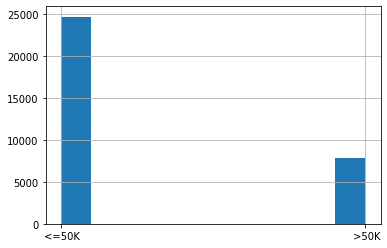

In [0]:
df_raw['income'].sort_values().hist()

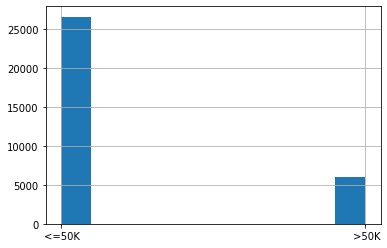

In [0]:
df_fake['income'].sort_values().hist()

C:\Users\Michael Kam\AppData\Roaming\Python\Python36\site-packages\pandas\plotting\_matplotlib\converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


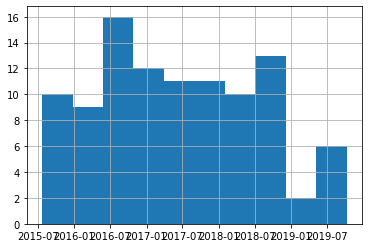

In [0]:
df_fake['App Date'].hist()

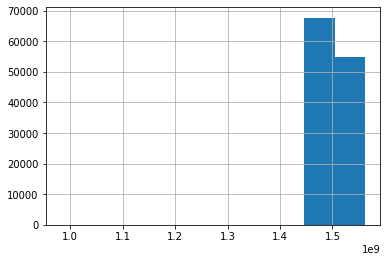

In [0]:
df_raw['App Date'].hist()

In [0]:
df_fake_100k = df_fake.copy()

In [0]:
df_fake_10k = df_fake.copy()

Text(0.5, 1.0, 'Income')

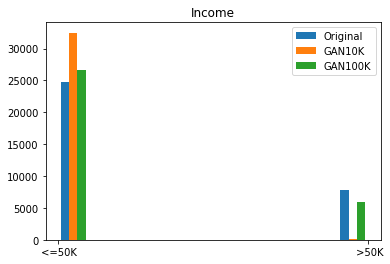

In [0]:
#df_raw.income.hist(alpha=1, label='Original', color='green', stacked=False)
#df_fake.income.hist(alpha=1, label='Synthetic', stacked=False)
inc_hist = np.array([df_raw.income, df_fake_10k.income,df_fake_100k.income]).T
category = ['Original', 'GAN10K','GAN100K',]
pyplot.hist(inc_hist, histtype='bar', label=category)
pyplot.legend(loc='upper right')
pyplot.title('Income')

Text(0.5, 1.0, 'hours.per.week')

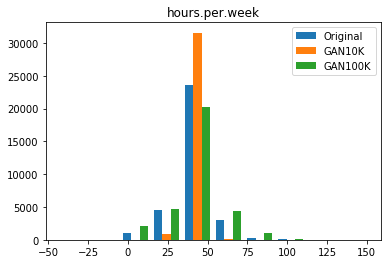

In [0]:
column = 'hours.per.week'

hist_ = np.array([df_raw[column], df_fake_10k[column],df_fake_100k[column]]).T
category = ['Original', 'GAN10K','GAN100K',]
pyplot.hist(hist_, histtype='bar', label=category)
pyplot.legend(loc='upper right')
pyplot.title(column)

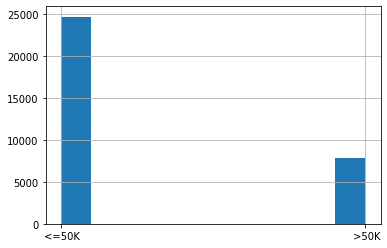

In [0]:
df_raw.income.hist()

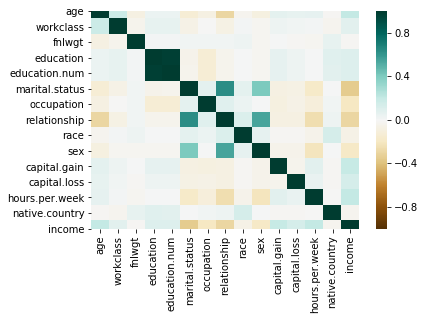

In [0]:
sns.heatmap(df.corr(), xticklabels = df.columns, yticklabels = df.columns, center = 0,vmin=-1, vmax=1.0, cmap="BrBG")

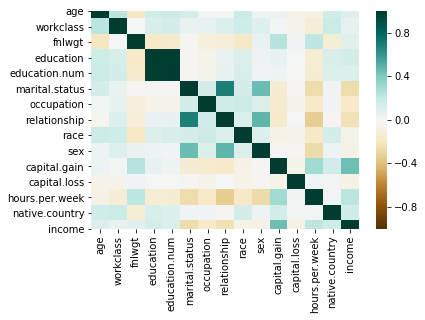

In [0]:
sns.heatmap(df_fake_norm.corr(), xticklabels = df_fake_norm.columns, yticklabels = df_fake_norm.columns, center = 0, vmin = -1, vmax=1.0, cmap="BrBG")

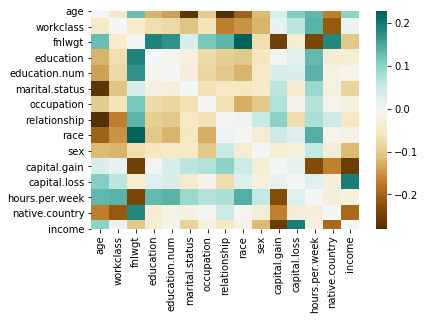

In [0]:
sns.heatmap(df.corr() - df_fake_norm.corr(), center = 0, cmap="BrBG")

In [0]:

df_fake_cd = df_fake_100k.copy()
df_ori_cd = df_raw.copy()

for col in cat_features:
    labelEncoder = LabelEncoder()
    df_fake_cd.loc[:, col] = labelEncoder.fit_transform(df_fake_cd.loc[:,col])
    df_ori_cd.loc[:, col] = labelEncoder.fit_transform(df_ori_cd.loc[:,col])

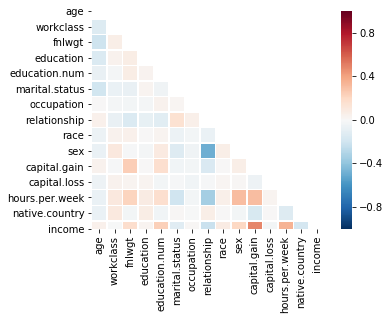

In [0]:
corr = df_fake_cd.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, square=True, linewidths=.5,center = 0,vmin=-1, vmax=1.0, cmap="RdBu_r")

In [0]:
df_fake_100k[np.logical_and(df_fake_100k.age == 29, df_fake_100k['capital.gain'] == 14)]

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,29,Private,129287,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,White,Female,14,4,64,United-States,<=50K
3921,29,Private,160387,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,14,4,53,United-States,<=50K
11722,29,Private,218271,Some-college,10,Never-married,Sales,Not-in-family,White,Female,14,4,39,United-States,<=50K
14188,29,Private,126374,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,14,4,60,United-States,<=50K
15532,29,Private,215920,Some-college,10,Never-married,Sales,Not-in-family,White,Female,14,4,39,United-States,<=50K
20838,29,Private,198893,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,14,3,47,United-States,<=50K
26483,29,Private,173831,Assoc-voc,11,Married-civ-spouse,Sales,Husband,White,Male,14,4,41,Cambodia,>50K
30961,29,Private,144526,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,14,3,42,United-States,<=50K


In [0]:
df_fake_cd[np.logical_and(df_fake_cd.age == 29, df_fake_cd['capital.gain'] == 14)]

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,29,4,129287,15,9,2,7,0,4,0,14,4,64,39,0
3921,29,4,160387,15,9,2,7,0,4,1,14,4,53,39,0
11722,29,4,218271,15,9,4,12,1,4,0,14,4,39,39,0
14188,29,4,126374,11,8,2,4,0,4,1,14,4,60,39,0
15532,29,4,215920,15,9,4,12,1,4,0,14,4,39,39,0
20838,29,4,198893,11,8,2,3,0,4,1,14,3,47,39,0
26483,29,4,173831,8,10,2,12,0,4,1,14,4,41,1,1
30961,29,4,144526,11,8,2,3,0,4,1,14,3,42,39,0


In [0]:
df_raw[df_raw.age == 29]

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
49,29,Private,271466,Assoc-voc,11,Never-married,Prof-specialty,Not-in-family,White,Male,0,0,43,United-States,<=50K
64,29,Private,105598,Some-college,10,Divorced,Tech-support,Not-in-family,White,Male,0,0,58,United-States,<=50K
72,29,Self-emp-not-inc,162298,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,70,United-States,>50K
95,29,Local-gov,115585,Some-college,10,Never-married,Handlers-cleaners,Not-in-family,White,Male,0,0,50,United-States,<=50K
104,29,Private,103432,HS-grad,9,Never-married,Craft-repair,Not-in-family,White,Male,0,0,40,United-States,<=50K
123,29,State-gov,267989,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,>50K
158,29,Private,191535,HS-grad,9,Divorced,Craft-repair,Not-in-family,White,Male,0,0,60,United-States,<=50K
292,29,Local-gov,220419,Bachelors,13,Never-married,Protective-serv,Not-in-family,White,Male,0,0,56,United-States,<=50K
318,29,Private,423158,Some-college,10,Never-married,Tech-support,Not-in-family,White,Female,0,0,40,United-States,<=50K
323,29,Private,200381,11th,7,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States,<=50K


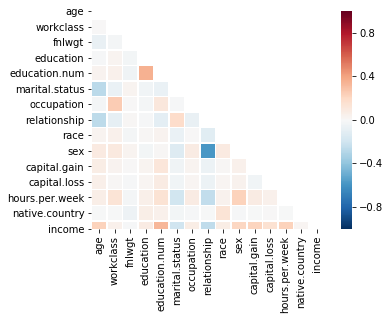

In [0]:
#for col in cat_features:
#    labelEncoder = LabelEncoder()
#    df_ori_cd.loc[:, col] = labelEncoder.fit_transform(df_ori_cd.loc[:,col])

corr = df_ori_cd.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, square=True, linewidths=.5,center = 0,vmin=-1, vmax=1.0, cmap="RdBu_r")

# Utility - XGBoost Classification

In [0]:
X_real = df_raw.iloc[:,:-1]
y_real = df_raw.iloc[:,-1]
X_fake = df_fake.iloc[:,:-1]
y_fake = df_fake.iloc[:,-1]

In [0]:
from sklearn.preprocessing import LabelEncoder

for col in cat_features:
    labelEncoder = LabelEncoder()
    if col != 'income':
        X_fake.loc[:, col] = labelEncoder.fit_transform(X_fake.loc[:,col])
    else:
        y_fake = labelEncoder.fit_transform(y_fake)


In [0]:
for col in cat_features:
    labelEncoder = LabelEncoder()
    if col != 'income':
        X_real.loc[:, col] = labelEncoder.fit_transform(X_real.loc[:,col])
    else:
        y_real = labelEncoder.fit_transform(y_real)

In [0]:
seed = 7777
test_size = 0.2
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(X_real, y_real, test_size=test_size, random_state=seed)
X_train_fake, X_test_fake, y_train_fake, y_test_fake = train_test_split(X_fake, y_fake, test_size=test_size, random_state=seed)

### Train and Test on Original

In [0]:
# fit model no training data
from xgboost import XGBClassifier
xgb_model = XGBClassifier()
xgb_model.fit(X_train_real, y_train_real)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [0]:
# make predictions for test data
y_pred_real = xgb_model.predict(X_test_real)
predictions = [round(value) for value in y_pred_real]

# evaluate predictions
accuracy = accuracy_score(list(y_test_real), predictions)
print("Accuracy: ",  accuracy * 100.0)

Accuracy:  86.13542146476279


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### Train on Synthetic and Test on Original 

In [0]:
# fit model no training data
xgb_model = XGBClassifier()
xgb_model.fit(X_train_fake, y_train_fake)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [0]:
# make predictions for test data
y_pred_real = xgb_model.predict(X_test_real)
predictions = [round(value) for value in y_pred_real]

# evaluate predictions
accuracy = accuracy_score(list(y_test_real), predictions)
print("Accuracy: ",  accuracy * 100.0)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy:  75.6947643175188


### Train and test on Synthetic 

In [0]:
# make predictions for test data
y_pred_fake = xgb_model.predict(X_test_fake)
predictions = [round(value) for value in y_pred_fake]

# evaluate predictions
accuracy = accuracy_score(list(y_test_fake), predictions)
print("Accuracy: ",  accuracy * 100.0)

Accuracy:  99.89252264701366


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [0]:
# fit model no training data
xgb_model = XGBClassifier()
xgb_model.fit(X_train_fake, y_train_fake)

# make predictions for test data
y_pred_fake = xgb_model.predict(X_test_fake)
predictions = [round(value) for value in y_pred_fake]

# evaluate predictions
accuracy = accuracy_score(list(y_test_fake), predictions)
print("Accuracy: ",  accuracy * 100.0)

Accuracy:  99.89252264701366


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


interval_cols not set, guessing: ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']


C:\Users\Michael Kam\AppData\Roaming\Python\Python36\site-packages\phik\binning.py:68: UserWarning: Empty bin with bin-edges 49999.5 - 59999.399999999994
  warnings.warn('Empty bin with bin-edges {0:s} - {1:s}'.format(str(bin_edges[i-1]), str(bin_edges[i])))
C:\Users\Michael Kam\AppData\Roaming\Python\Python36\site-packages\phik\binning.py:68: UserWarning: Empty bin with bin-edges 59999.399999999994 - 69999.3
  warnings.warn('Empty bin with bin-edges {0:s} - {1:s}'.format(str(bin_edges[i-1]), str(bin_edges[i])))
C:\Users\Michael Kam\AppData\Roaming\Python\Python36\site-packages\phik\binning.py:68: UserWarning: Empty bin with bin-edges 69999.3 - 79999.2
  warnings.warn('Empty bin with bin-edges {0:s} - {1:s}'.format(str(bin_edges[i-1]), str(bin_edges[i])))
C:\Users\Michael Kam\AppData\Roaming\Python\Python36\site-packages\phik\binning.py:68: UserWarning: Empty bin with bin-edges 79999.2 - 89999.09999999999
  warnings.warn('Empty bin with bin-edges {0:s} - {1:s}'.format(str(bin_edges[i-1

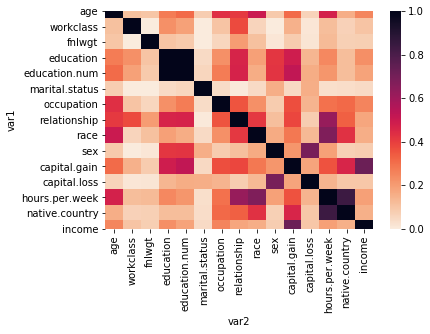

In [0]:
#phik.report.correlation_report(df)
sns.heatmap(df_raw.phik_matrix(), xticklabels = df_raw.columns, yticklabels = df_raw.columns, cmap=sns.cm.rocket_r)

interval_cols not set, guessing: ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']


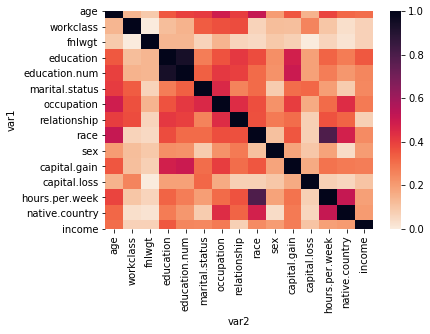

In [0]:
sns.heatmap(df_fake.phik_matrix(), xticklabels = df_fake.columns, yticklabels = df_fake.columns, cmap=sns.cm.rocket_r)

In [0]:
#df_fake_norm.to_csv('License_Fake_Norm.csv', index=False)
#df_fake.to_csv('License_Fake.csv', index=False)
#pd.DataFrame.from_dict(catFeatureMap).to_csv('Feature_Map.csv', index=False)
pd.DataFrame(shortest_dist).to_csv('Adult_10k_Distance.csv', index=False)

## Record Linkage

In [0]:
#!pip install recordlinkage

In [0]:
import recordlinkage
indexer = recordlinkage.Index()
indexer.full()
pairs = indexer.index(df_raw, df_fake)

W0825 20:50:51.404345 18644 index.py:46] indexing - performance warning - A full index can result in large number of record pairs.


In [0]:
# Comparing Step
compare_cl = recordlinkage.Compare()

for col in colnames:
    compare_cl.numeric(col, col)

rec_features = compare_cl.compute(pairs, df_raw, df_fake)

In [0]:
# Classification step
for i in np.arange(3, len(colnames)):
    matches = rec_features[rec_features.sum(axis=1) >= i]
    print("Record Linkage >= %d the value %d" % (i ,len(matches)))


Record Linkage >= 3 the value 37394
Record Linkage >= 4 the value 3456
Record Linkage >= 5 the value 181
Record Linkage >= 6 the value 1
Record Linkage >= 7 the value 0
Record Linkage >= 8 the value 0
